In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Реализована модель "вертолета":

1. Вертолет движется только по вертикали
2. Обдалает свойством инерции
3. Может разогнаться до скорости `v = 90 м/с`

* На величину ускорения свободного падения оказывает влияние высота, на которой находится модель (в соответствии с законами физики)
* У модели имеется "инерция винта" - тяга не может измениться с минимального до максимального значение, а делает это постепенно (`20 с необходимо для набора половины значения силы тяги с 0`)

Входные и парметры модели:
* На вход подается изменение силы тяги (в %), на которое необходимо скорректировать текущую силу
* На выходе - высота

Дифференциальное уравнение для регулирования высоты:
${H''} = \frac{F}{m} - {g} - sign({H'})*(\frac{H'}{v_m})^{2}$<br>
 - ${F}$ - тяга, не зависит от ${t}$<br>
 - ${g}$ - ускорение свободного падения. $\lim \frac{dg}{dt} = 0$, поэтому для уравнения будем считать его константой <br>
 - $sign({H'})*(\frac{H'}{v_m})^{2}$ - аналог силы сопротивления воздуха. <br><br>
 Целевое уравнение:
${dv} = ({k} - 1 - {sign(v)}(\frac{v}{v_m})^{2}) * {g} * {dt}$ <br>

* Допущения: максимальная тяга - не более ${2mg}$, сила сопроитвления воздуха - не более ${mg}$

In [ ]:
class BlackBox:
    def __init__(self, start_height: int = 0):
        # Earth's radius
        self._R = 6376545

        # Model constant params
        self._vmax = 90
        self._f_threshold = 0.5
        self._max_df_dt = self._f_threshold / 20  # 20s is the time to reach 50% F

        # Approximation params
        self._v = 0.
        self._abs_H = self._R + start_height

        # Model variable params
        self.H = 0
        self.F = 0.

    # Calculates g acceleration based on current height
    def _calc_g(self):
        return 9.80665 * self._R**2 / (self._abs_H + self.H)**2

    def step(self, df: float = 0., dt: float = 1):
        # Applying inertia to df (rotor can't switch its speed instantly)
        if abs(df / dt) > self._max_df_dt:
            da = self._max_df_dt * np.sign(df)
        else:
            da = df / dt

        # Clipping the thrust, so it stays within [0, 1] range
        f_prev = self.F
        self.F = np.clip(self.F + da, 0, 1)
        g = self._calc_g()

        dv = 0.
        # Takeoff or crash scenario
        if self.F <= self._f_threshold and self.H <= (self._abs_H - self._R):

            self._v = 0
        # Lifting power < mg but the object is not on a surface
        else:
            self._v += ((self.F - 0) / self._f_threshold - 1 - np.sign(self._v) *
                                    (self._v / self._vmax) ** 2) * g * dt

        self.H += self._v * dt

        # "Crash" scenario, compares with the starting height value (0 by default)
        if self.H <= (self._abs_H - self._R) and self._v != 0:
            self.H = 0
            self._v = 0

        return

In [ ]:
class PID:
    def __init__(self, p, i, d):
        self.p = p
        self.i = i
        self.d = d
        self.prev_err = 0
        self.integral = 0

    def step(self, target, measured, dt):
        err = target - measured
        self.integral += err * dt
        deriv = (err - self.prev_err) / dt
        output = self.p * err + self.i * self.integral + self.d * deriv
        self.prev_err = err

        return output

Первый эксперимент - поддержание тяги. Будем моделировать 1000 шагов по 0.1 с. Целевая тяга - 60%, время поддержания - 1 минута.

In [ ]:
# Allowing PID to maintain thrust for 1 min only
def experiment_v1(pid: PID) -> None:
    # Setting experiment params
    dt = 0.1
    size = 1000
    f = np.zeros(size)
    inputs = np.zeros(size)
    h = np.zeros(size)
    bb = BlackBox()
    target = 0.6
    # Max allowed regulation error value
    err_threshold = 0.0001
    # For graphics auxiliary plots
    start_point, end_point = 0, 0
    # For period measurement
    counter, is_measured = 0, False

    for i in range(1, size):
        # Get PID correction
        inp = pid.step(target, bb.F, dt)
        bb.step(inp, dt)

        # Looking for period entry point
        if abs(bb.F - target) < err_threshold and not is_measured:
            if counter == 0:
                start_point = i
            counter += 1
        # Entry point was found but condition is not stable yet
        elif counter > 0 and not is_measured:
            counter = 0

        # Looking for period end point
        if counter == 601:
            end_point = i
            is_measured = True
            target = 0
            counter = 0

        # Saving values for plotting
        f[i] = bb.F
        inputs[i] = inp
        h[i] = bb.H

    plt.plot(f)
    plt.title(f"Thrust per time\n1 iteration ~ {dt}s", loc="left")
    plt.xlabel("Iterations")
    plt.ylabel("Thrust, %")
    plt.axhline(y=0.6, color='k', linestyle='dotted')
    plt.axvline(x=start_point, color='b', linestyle='dashed', label=f"Start: {start_point}", linewidth=0.7)
    plt.axvline(x=end_point, color='r', linestyle='dashed', label=f"End: {end_point}", linewidth=0.7)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Delta, s: {(end_point - start_point) * dt:.1f}", alpha=0)
    plt.legend()
    plt.show()

    plt.plot(np.clip(inputs, -1, 1.5))
    plt.title(f"PID output per time\n1 iteration ~ {dt}s", loc="left")
    plt.xlabel("Iterations")
    plt.ylabel("PID thrust correction, %")
    plt.axvline(x=start_point, color='b', linestyle='dashed', label=f"Start: {start_point}", linewidth=0.7)
    plt.axvline(x=end_point, color='r', linestyle='dashed', label=f"End: {end_point}", linewidth=0.7)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Delta, s: {(end_point - start_point) * dt:.1f}", alpha=0)
    plt.legend()
    plt.show()

    plt.plot(h)
    plt.title(f"Model height per time\n1 iteration ~ {dt}s", loc="left")
    plt.xlabel("Iterations")
    plt.ylabel("Height, m")
    plt.axvline(x=start_point, color='b', linestyle='dashed', label=f"Start: {start_point}", linewidth=0.7)
    plt.axvline(x=end_point, color='r', linestyle='dashed', label=f"End: {end_point}", linewidth=0.7)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Delta, s: {(end_point - start_point) * dt:.1f}", alpha=0)
    plt.legend()
    plt.show()

    return None

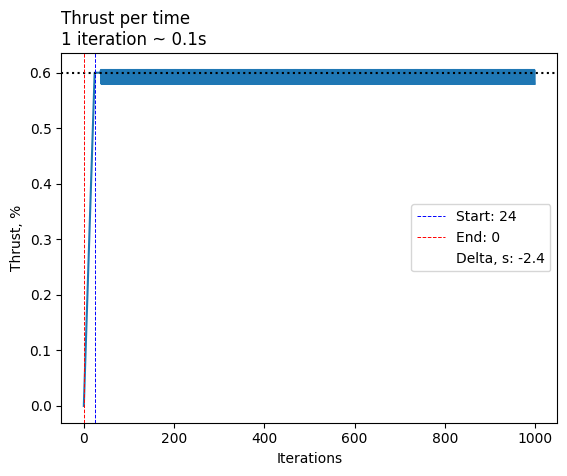

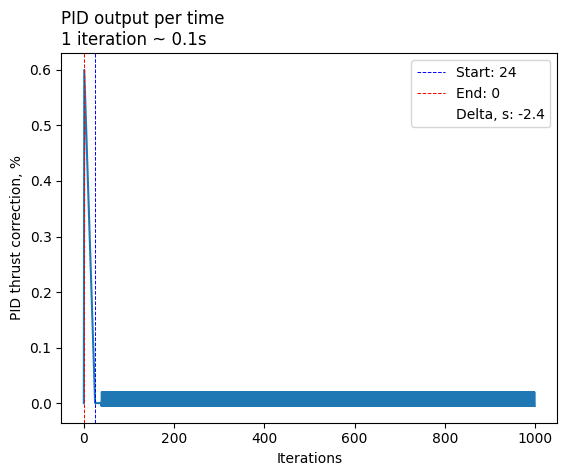

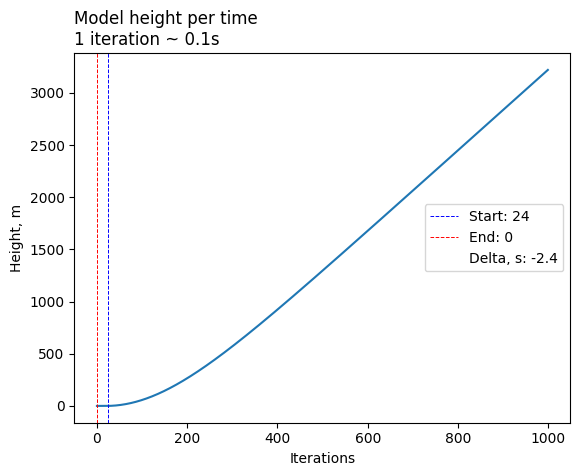

In [ ]:
experiment_v1(PID(0.04, 0, 0))

Второй эксперимент - поддержание высоты. Будем моделировать 50000 шагов по 0.1 с.
 * Целевая высота - 2000 м
 * время поддержания - 10 минут
 * точность поддержания: 2 метра

In [ ]:
# Allowing PID to maintain height = 2000 meters for 10 minutes
def experiment_v2(pid: PID) -> None:
    # Setting experiment params
    dt = 0.1
    size = 50000
    f = np.zeros(size)
    inputs = np.zeros(size)
    h = np.zeros(size)
    bb = BlackBox()
    target = 2000
    # Max allowed regulation error value
    err_threshold = 2
    # For graphics auxiliary plots
    start_point, end_point = 0, 0
    # For period measurement
    counter, is_measured = 0, False

    for i in range(1, size):
        # Get PID correction
        inp = pid.step(target, bb.H, dt)
        bb.step(inp, dt)

        # Looking for period entry point
        if abs(bb.H - target) < err_threshold and not is_measured:
            if counter == 0:
                start_point = i
            counter += 1
        # Entry point was found but condition is not stable yet
        elif counter > 0 and not is_measured:
            counter = 0

        # Looking for period end point
        if counter == 6001:
            end_point = i
            is_measured = True
            counter = 0

        # Saving values for plotting
        f[i] = bb.F
        inputs[i] = inp
        h[i] = bb.H
    """
    plt.plot(np.clip(f, -1, 1.5))
    plt.title(f"Thrust per time\n1 iteration ~ {dt}s", loc="left")
    plt.xlabel("Iterations")
    plt.ylabel("Thrust, %")
    plt.axvline(x=start_point, color='b', linestyle='dashed', label=f"Start: {start_point}", linewidth=0.7)
    plt.axvline(x=end_point, color='r', linestyle='dashed', label=f"End: {end_point}", linewidth=0.7)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Delta, s: {(end_point - start_point) * dt:.1f}", alpha=0)
    plt.legend()
    plt.show()

    plt.plot(np.clip(inputs, -1, 1.5))
    plt.title(f"PID output per time\n1 iteration ~ {dt}s", loc="left")
    plt.xlabel("Iterations")
    plt.ylabel("PID thrust correction, %")
    plt.axvline(x=start_point, color='b', linestyle='dashed', label=f"Start: {start_point}", linewidth=0.7)
    plt.axvline(x=end_point, color='r', linestyle='dashed', label=f"End: {end_point}", linewidth=0.7)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Delta, s: {(end_point - start_point) * dt:.1f}", alpha=0)
    plt.legend()
    plt.show()
    """
    plt.plot(h)
    plt.title(f"Model height per time\n1 iteration ~ {dt}s", loc="left")
    plt.xlabel("Iterations")
    plt.ylabel("Height, m")
    plt.axvline(x=start_point, color='b', linestyle='dashed', label=f"Start: {start_point}", linewidth=0.7)
    plt.axvline(x=end_point, color='r', linestyle='dashed', label=f"End: {end_point}", linewidth=0.7)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Delta, s: {(end_point - start_point) * dt:.1f}", alpha=0)
    plt.legend()
    plt.show()

    return None

Подбираем коэффициенты PID контроллера:

__Проба #1:__ высота достигается, но не поддерживается

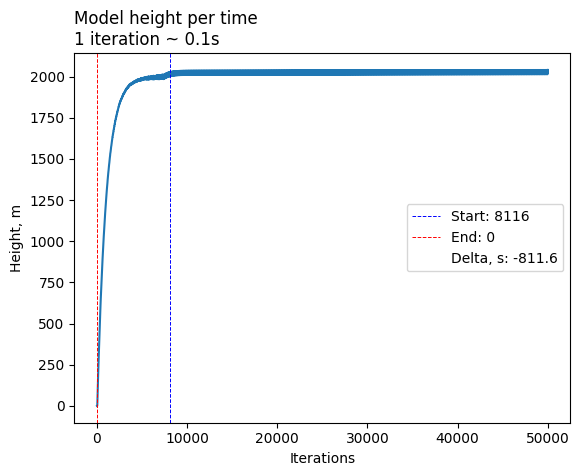

In [ ]:
experiment_v2(PID(0.01, 0.000000000000000001, 1))

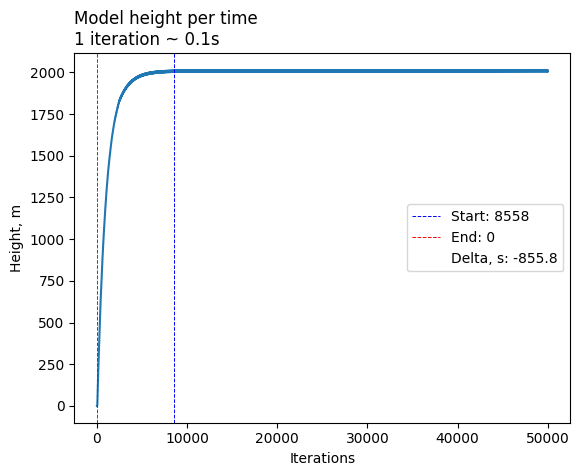

In [ ]:
experiment_v2(PID(1, 0.00000001, 100))

__Проба #2:__ минимальная раскачка модели на высоте, амплитуда порядка 0.5 метра

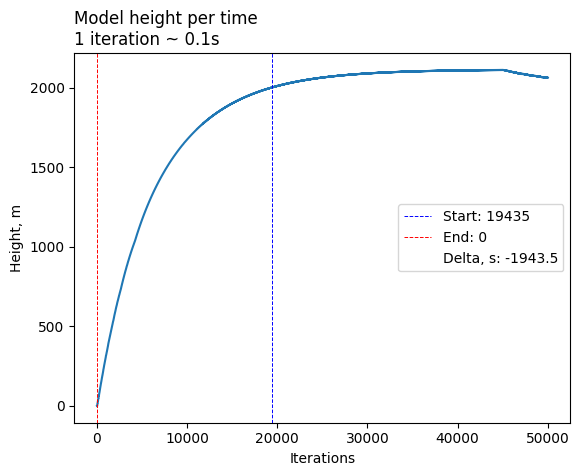

In [ ]:
experiment_v2(PID(0.007, 0.00000025, 4))

__Проба #3:__ высота поддерживается, раскачка больше, период раскачки ~ 150 секунд

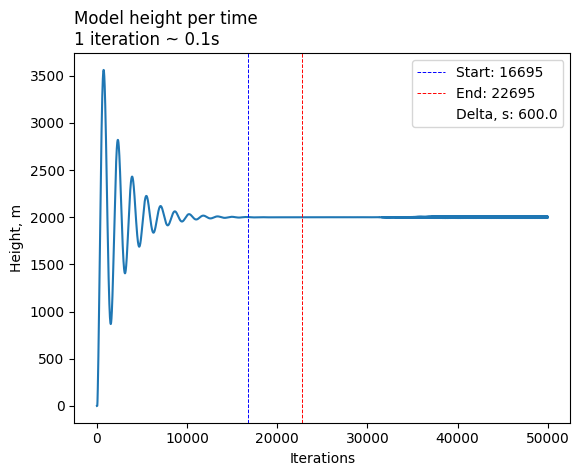

In [ ]:
experiment_v2(PID(0.00004, 0.000008, 0.005))

__Вывод:__ система имеет низкую стабильность при данной постановке задачи, а также имеющихся параметрах модели. <br>
Разобьем эксперимент на составные части и дополним:
 * "Вертолет" поднимается на высоту 2000 метров и остается на ней на 10 минут
 * Минимизируем время подъема
 * Допустимая погрешность поддержания высоты: 10 метров
 * По истечение 10 минут опускаем вертолет
 * Стараемся не разбить "вертолет" об землю :) <br>
_В ходе эксперимента будем менять параметры PID контроллера для достижения локальных задач._

In [ ]:
# Allowing PID to maintain height for 30 sec only
def experiment_v3() -> None:
    # Setting experiment params
    dt = 0.1
    size = 50000
    f = np.zeros(size)
    inputs = np.zeros(size)
    h = np.zeros(size)
    bb = BlackBox()
    # Max allowed regulation error value
    err_threshold = 10
    # For graphics auxiliary plots
    start_point, end_point = 0, 0
    # For period measurement
    counter, is_measured = 0, False
    time_limit = 6001

    indx = 0
    target = 1500
    pid = PID(1, 0, 0)
    while indx < len(inputs) and bb.H < target:
        # Get PID correction
        inp = pid.step(target, bb.H, dt)
        bb.step(inp, dt)

        # Saving values for plotting
        f[indx] = bb.F
        inputs[indx] = inp
        h[indx] = bb.H

        indx += 1

    target = 2000
    pid = PID(0.00004, 0.000008, 0.01)
    while indx < len(inputs) and bb.H < target:
        # Get PID correction
        inp = pid.step(target, bb.H, dt)
        bb.step(inp, dt)

        # Saving values for plotting
        f[indx] = bb.F
        inputs[indx] = inp
        h[indx] = bb.H

        indx += 1

    start_point = indx
    target = 2000
    pid = PID(0.00003, 0.000008, 0.005)
    while indx < len(inputs) and (counter < time_limit or not is_measured):
        # Get PID correction
        inp = pid.step(target, bb.H, dt)
        bb.step(inp, dt)

        # Looking for period entry point
        if abs(bb.H - target) < err_threshold and not is_measured:
            if counter == 0:
                pass
                start_point = indx
            counter += 1
        # Entry point was found but condition is not stable yet
        elif counter > 0 and not is_measured:
            counter = 0

        # Looking for period end point
        if counter == time_limit:
            end_point = indx
            is_measured = True
            # counter = 0

        # Saving values for plotting
        f[indx] = bb.F
        inputs[indx] = inp
        h[indx] = bb.H

        indx += 1

    pid = PID(0.00004, 0.000008, 0.01)
    local_counter = 0
    target -= 50
    while indx < len(inputs) and target > 0:
        # Get PID correction
        inp = pid.step(target, bb.H, dt)
        bb.step(inp, dt)

        # Saving values for plotting
        f[indx] = bb.F
        inputs[indx] = inp
        h[indx] = bb.H

        indx += 1
        local_counter += 1

        if local_counter % 200 == 0:
            target -= 50

    pid = PID(1, 5, 1400)
    target = 0
    local_counter = 0
    landing_speed = bb._v
    while indx < len(inputs) and bb.H > target:
        # Get PID correction
        landing_speed = bb._v
        inp = pid.step(target, bb.H, dt)
        bb.step(inp, dt)

        # Saving values for plotting
        f[indx] = bb.F
        inputs[indx] = inp
        h[indx] = bb.H

        indx += 1

    plt.plot(h)
    plt.title(f"Model height per time\n1 iteration ~ {dt}s", loc="left")
    plt.xlabel("Iterations")
    plt.ylabel("Height, m")
    plt.axvline(x=start_point, color='b', linestyle='dashed', label=f"Start: {start_point}", linewidth=0.7)
    plt.axvline(x=end_point, color='r', linestyle='dashed', label=f"End: {end_point}", linewidth=0.7)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Delta, s: {(end_point - start_point) * dt:.1f}", alpha=0)
    plt.axhline(y=0, color='w', linestyle='dotted', label=f"Landing speed: {landing_speed:.1f} m/s", alpha=0)
    plt.legend()
    plt.show()

    return None

__Эксперимент #3__

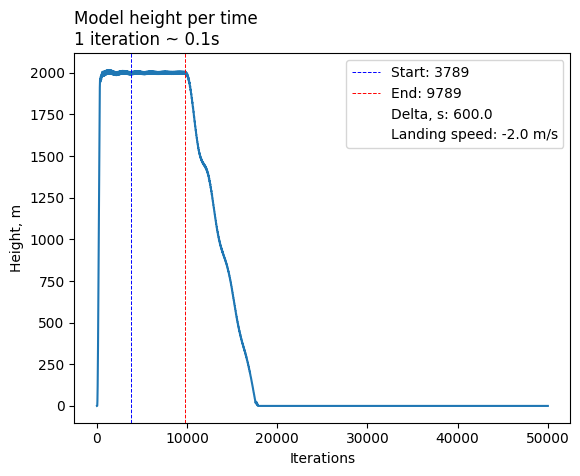

In [ ]:
experiment_v3()